In [65]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
import pickle
from rich import print

In [66]:
warnings.filterwarnings("ignore", message="Workbook contains no default style, apply openpyxl's default")
warnings.simplefilter(action='ignore', category=FutureWarning)

folder_path = 'TothSpreadsheets'

## 1. Data distribution analysis

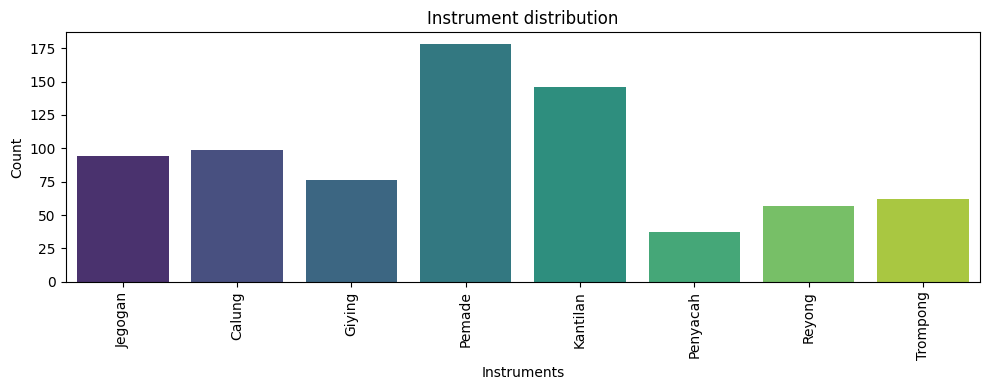

In [67]:
instruments_count = {}
for file_name in os.listdir(folder_path):
    if file_name.startswith('Toth') and file_name.endswith('.xlsx'):
        file_path = os.path.join(folder_path, file_name)
        df = pd.read_excel(file_path)
        labels = df.iloc[3:, 0].tolist()
        for label in labels:
            instruments_count[label] = instruments_count.get(label, 0) + 1
            if pd.isna(label):
                print(f'Empty label in {file_name}')

data = pd.DataFrame({'Labels': list(instruments_count.keys()), 'Count': list(instruments_count.values())})
plt.figure(figsize=(10, 4))
sns.barplot(x='Labels', y='Count', data=data, palette='viridis')
plt.xlabel('Instruments')
plt.ylabel('Count')
plt.title('Instrument distribution')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# print(instruments_count)

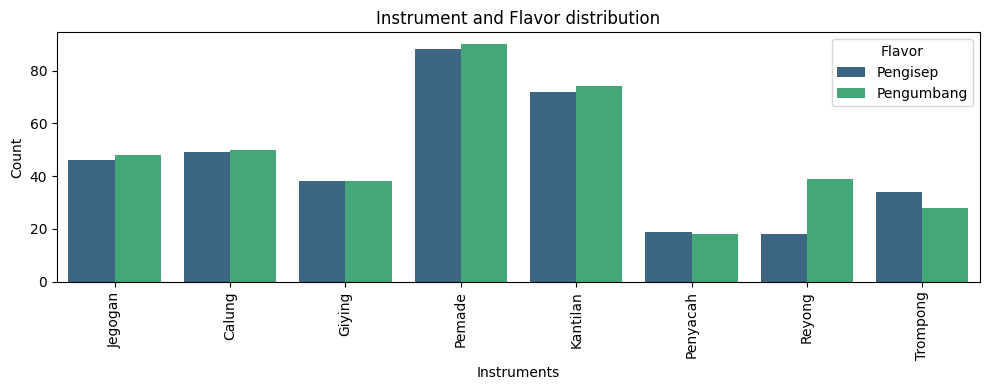

In [68]:
classification = {}
for file_name in os.listdir(folder_path):
    if file_name.startswith('Toth') and file_name.endswith('.xlsx'):
        file_path = os.path.join(folder_path, file_name)
        df = pd.read_excel(file_path)
        for _, row in df.iloc[3:].iterrows():
            label, value = row[0:2]
            if label not in classification:
                classification[label] = {'Pengisep': 0, 'Pengumbang': 0}
            if value == '+':
                classification[label]['Pengisep'] += 1
            elif value == '-':
                classification[label]['Pengumbang'] += 1

data = pd.DataFrame([(label, flavor, count) for label, flavor_dict in classification.items() for flavor, count in flavor_dict.items()], columns=['Instruments', 'Flavor', 'Count'])
plt.figure(figsize=(10, 4))
sns.barplot(x='Instruments', y='Count', hue='Flavor', data=data, palette='viridis')
plt.legend(title='Flavor')
plt.xlabel('Instruments')
plt.ylabel('Count')
plt.title('Instrument and Flavor distribution')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

## 2. Pemade dataset creation

In this part of the notebook we will iterate through all the spreadsheets in the Toth dataset and create a dataframe storing the relevant data related to the Pemade instrument. This dataframe will be stored as a pickle in `pickles/dataset.pkl`.

In [69]:
# Ignore some gamelans
gamelan_blacklist = ["Kalapaksa", "Br Kawan Bangli", "Sidembunut"]

# Define dataset variables
gamelan_data = {}
dataset_labels = ["Region", "Gamelan", "Flavor", "ding3", "dong3", "deng3", "dung3", "dang3", "ding4"]
dataset_df = pd.DataFrame([], columns=dataset_labels)

# Iterate through all spreadsheets
for file_name in os.listdir(folder_path):
    if file_name.startswith("Toth") and file_name.endswith(".xlsx"):
        # Get file path
        file_path = os.path.join(folder_path, file_name)
        
        # Read Excel file
        df = pd.read_excel(file_path, header=None)
        
        # Get gamelan name and regency name
        gamelan_name = df.iloc[0, 0]
        regency_name = df.iloc[1, 0]

        # Skip blacklisted gamelan
        if gamelan_name in gamelan_blacklist: continue

        # Organize labels
        labels = df.iloc[3, :].tolist()
        labels[0], labels[1] = "Instrument", "Flavor"
        oct_labels = []
        count = 0
        for label in labels:
            if label in ["Instrument", "Flavor"]:
                oct_labels.append(label)
                continue
            if label == "ding": count += 1
            oct_labels.append(f"{label}{count}")

        # Get the pemade data
        pemade_pengumbang = pd.Series([np.nan] * len(oct_labels))
        pemade_pengisep = pd.Series([np.nan] * len(oct_labels))
        pemade_df = pd.DataFrame([], columns=oct_labels)
        for index, row in df.iterrows():
            if index >= 4:
                instrument = row[0]
                if instrument == "Pemade":
                    value_list = row.to_list()
                    count = sum(1 for value in value_list if pd.notna(value)) - 2
                    if count == 1: continue # There is one pemade with only one note :/
                    # print(value_list)
                    pemade_df = pd.concat([pemade_df, pd.DataFrame([value_list], columns=oct_labels)], ignore_index=True)
        
        # Filter the pemade data
        pemade_df = pemade_df[["Instrument", "Flavor", "ding3", "dong3", "deng3", "dung3", "dang3", "ding4"]]
        pemade_df.dropna(inplace=True)

        # Split the pemade data
        pemade_pengisep_df = pemade_df[pemade_df["Flavor"] == "+"]
        pemade_pengumbang_df = pemade_df[pemade_df["Flavor"] == "-"]

        # # Compute means
        # pemade_mean = pemade_df.iloc[:, 2:9].mean()
        # pemade_pengumbang_mean = pemade_pengumbang_df.iloc[:, 2:9].mean()
        # pemade_pengisep_mean = pemade_pengisep_df.iloc[:, 2:9].mean()

        # Append to the dictionary
        if not regency_name in gamelan_data: gamelan_data[regency_name] = {}
        gamelan_data[regency_name][gamelan_name] = {
            "pemade": pemade_df,
            "pemade+": pemade_pengisep_df,
            "pemade-": pemade_pengumbang_df,
        }

# Create the dataset
for regency, gamelan_dict in gamelan_data.items():
    for gamelan, gamelan_data_2 in gamelan_dict.items():
        pemade_data = gamelan_data_2["pemade"]
        pemade_pengumbang_data = gamelan_data_2["pemade+"]
        pemade_pengisep_data = gamelan_data_2["pemade-"]
        for index, row in pemade_data.iterrows():
            dataset_df = pd.concat([dataset_df, pd.DataFrame([[regency, gamelan, row["Flavor"], *row[2:]]], columns=dataset_labels)], ignore_index=True)
        for index, row in pemade_pengumbang_data.iterrows():
            dataset_df = pd.concat([dataset_df, pd.DataFrame([[regency, gamelan, row["Flavor"], *row[2:]]], columns=dataset_labels)], ignore_index=True)
        for index, row in pemade_pengisep_data.iterrows():
            dataset_df = pd.concat([dataset_df, pd.DataFrame([[regency, gamelan, row["Flavor"], *row[2:]]], columns=dataset_labels)], ignore_index=True)

# dataset_region_pengisep_df = dataset_df[dataset_df["Flavor"] == "+"]
# dataset_region_pengisep_means = dataset_region_pengisep_df.drop(columns=["Gamelan", "Flavor"])
# dataset_region_pengisep_means = dataset_region_pengisep_means.groupby("Region", as_index=False).mean()

# dataset_region_pengumbang_df = dataset_df[dataset_df["Flavor"] == "-"]
# dataset_region_pengumbang_means = dataset_region_pengumbang_df.drop(columns=["Gamelan", "Flavor"])
# dataset_region_pengumbang_means = dataset_region_pengumbang_means.groupby("Region", as_index=False).mean()

# dataset_region_df = dataset_df.copy()
# dataset_region_means = dataset_region_df.drop(columns=["Gamelan", "Flavor"])
# dataset_region_means = dataset_region_means.groupby("Region", as_index=False).mean()
            
pickle.dump(dataset_df, open("pickles/dataset.pkl", "wb"))
dataset_df

,Region,Gamelan,Flavor,ding3,dong3,deng3,dung3,dang3,ding4
0,Gianyar,Sumampan,-,553.1,595.2,644.6,810.7,873.4,1115.2
1,Gianyar,Sumampan,-,554.4,597.9,647.2,813.5,880.0,1117.1
2,Gianyar,Sumampan,+,561.5,603.1,652.1,818.2,883.1,1124.9
3,Gianyar,Sumampan,+,561.5,603.1,652.1,818.2,883.1,1124.9
4,Gianyar,Sumampan,-,553.1,595.2,644.6,810.7,873.4,1115.2
...,...,...,...,...,...,...,...,...,...
309,Bangli,Blungbang Bangli,+,484.3,533.0,582.9,738.7,848.1,992.3
310,Bangli,Blungbang Bangli,+,482.9,532.4,585.0,732.8,848.6,993.5
311,Bangli,Blungbang Bangli,+,484.3,533.0,582.9,738.7,848.1,992.3
312,Bangli,Blungbang Bangli,-,479.0,531.5,574.9,726.4,807.9,986.1


## 3. Tone analysis

In [70]:
# Load the data computed in the previous part from the pickle file
df = pd.read_pickle('pickles/dataset.pkl')

In [71]:
df_ding_540_545 = df[(df['ding3'] > 540) & (df['ding3'] < 545)]
gamelans_540_545 = df_ding_540_545[['Region', 'Gamelan']].drop_duplicates()
gamelan_count_540_545 = len(df_ding_540_545['Gamelan'].unique())
region_count_540_545 = len(df_ding_540_545['Region'].unique())
print(f'The number of unique gamelan with ding3 in the 540-545 Hz range is {gamelan_count_540_545}, distributed over {region_count_540_545} regions:')
gamelans_540_545

The number of unique gamelan with ding3 in the 540-545 Hz range is 9, distributed over 4 regions:

,Region,Gamelan
26,Gianyar,Pujung Kelod
58,Gianyar,"Pengosekan, Old"
142,Badung,SidakaryaTengah
184,Badung,Lebah Sadmerta
198,Badung,Br Tengah Sesetan
222,Tabanan,Br Kukuh Krambitan
229,Tabanan,Puri Kaleran Tabanan
244,Buleleng,Bubunan
264,Buleleng,Kedis Kaja


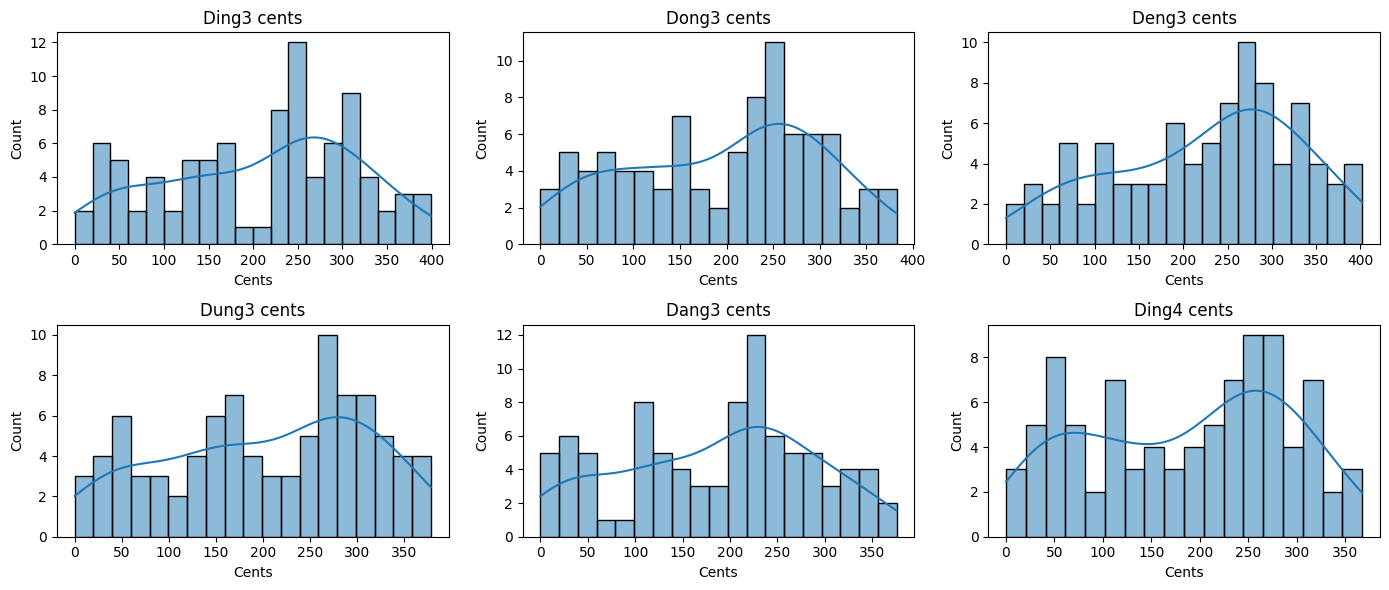

In [72]:
# in the datafreame, take the rows with equal region, gamelan and flavour and compute the mean of the selected columns
df_grouped = df.groupby(['Region', 'Gamelan', 'Flavor']).mean()

selisir_notes = ['ding3', 'dong3', 'deng3', 'dung3', 'dang3', 'ding4']
df_selisir_notes = df_grouped[selisir_notes]

# define a new  dictionary to store the cents values
dict_selisir_cents = {}

for column in df_selisir_notes.columns:
    # create the key for the dictionary
    key = column + '_cents'
    # store the values in a numpy array
    values = df_selisir_notes[column].values
    # get the minimum value
    min_value = values.min()
    for value in values:
        # compute the difference in cents
        cents = 1200 * np.log2(value / min_value)
        # append the value to the value in the corresponding key
        if key in dict_selisir_cents: dict_selisir_cents[key].append(cents)
        else: dict_selisir_cents[key] = [cents]

fig, axs = plt.subplots(2, 3, figsize=(14, 6))
axs = axs.flatten()
for i, (key, value) in enumerate(dict_selisir_cents.items()):
    sns.histplot(value, kde=True, binwidth=20, ax=axs[i])
    axs[i].set_xlabel('Cents')
    axs[i].set_title(key.replace('_', ' ').capitalize())

# Adjust layout
plt.tight_layout()
plt.show()

The gamelan with the highest ding3 frequency is Kokar with a frequency of 589.4 Hz

The gamelan with the lowest ding3 frequency is Sangkanabuana with a frequency of 467.20000000000005 Hz

The range of ding3 frequencies is 122.19999999999993 Hz

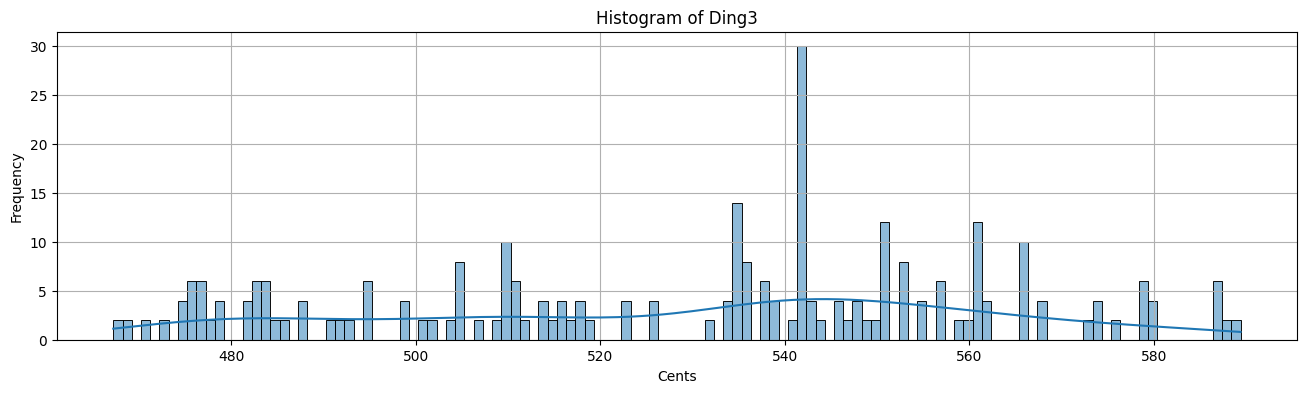

In [73]:
# get the ding3 with the highest frequency and the lowest frequency and plot them and their range and their corresponding audio
ding3_max = df["ding3"].idxmax()
ding3_min = df["ding3"].idxmin()
range_ding3 = df["ding3"].max() - df["ding3"].min()

print(f'The gamelan with the highest ding3 frequency is {df.iloc[ding3_max]["Gamelan"]} with a frequency of {df.iloc[ding3_max]["ding3"]} Hz')
print(f'The gamelan with the lowest ding3 frequency is {df.iloc[ding3_min]["Gamelan"]} with a frequency of {df.iloc[ding3_min]["ding3"]} Hz')
print(f"The range of ding3 frequencies is {range_ding3} Hz")

plt.figure(figsize=(16, 4))
sns.histplot(df["ding3"], kde=True, binwidth=1)
plt.title("Histogram of Ding3")
plt.xlabel("Cents")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

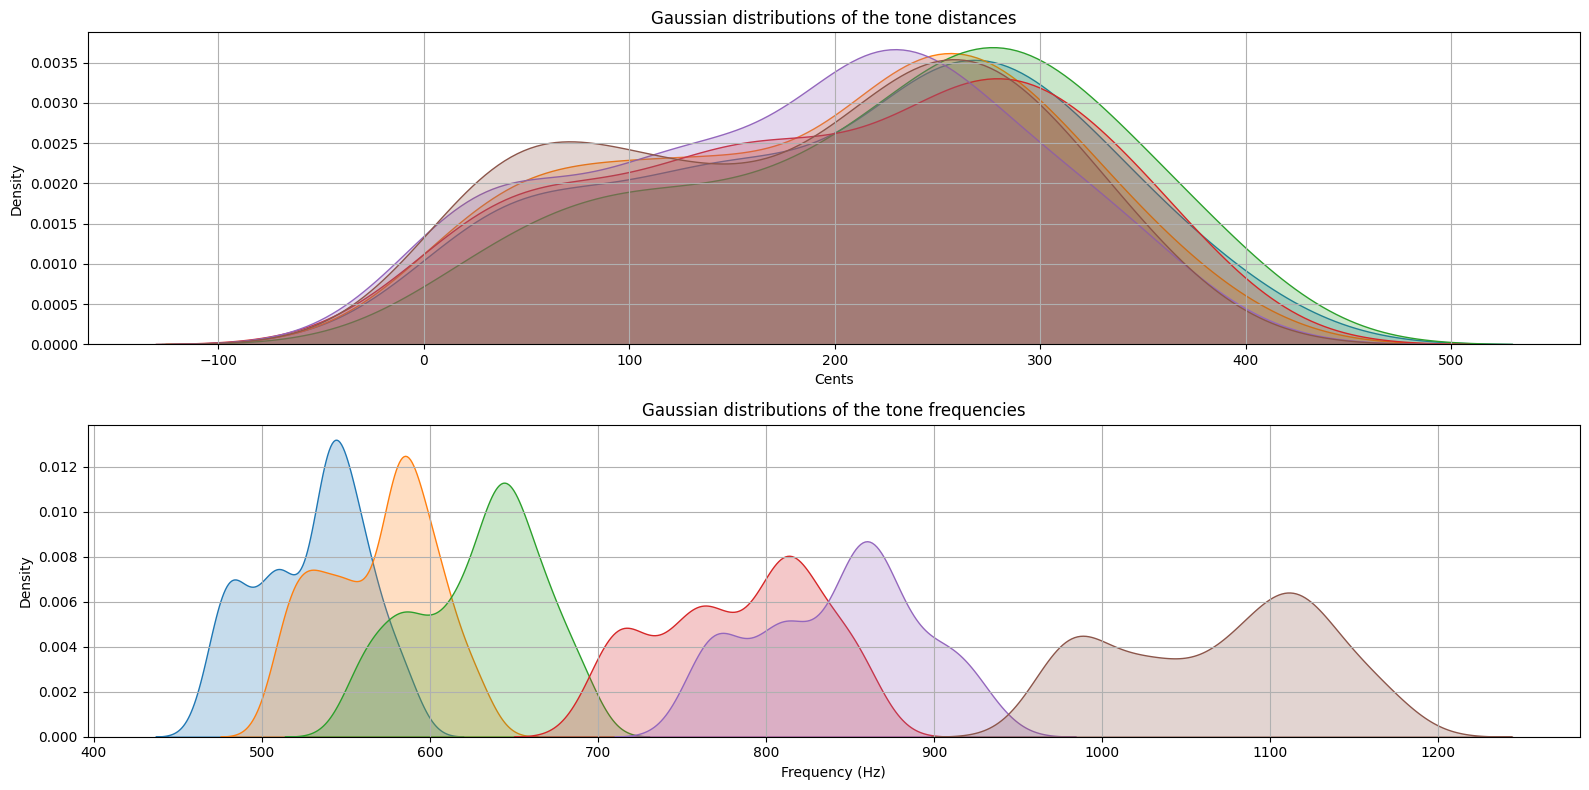

In [74]:
# Create a figure with 2 subplots vertically stacked
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

# Plot the first set of distributions
for key, value in dict_selisir_cents.items():
    sns.kdeplot(value, label=key, fill=True, ax=axs[0])
axs[0].set_title("Gaussian distributions of the tone distances")
axs[0].set_xlabel("Cents")
axs[0].set_ylabel("Density")
axs[0].grid(True)

# Plot the second set of distributions
for column in df_selisir_notes.columns:
    sns.kdeplot(df[column], label=column, fill=True, ax=axs[1])
axs[1].set_title("Gaussian distributions of the tone frequencies")
axs[1].set_xlabel("Frequency (Hz)")
axs[1].set_ylabel("Density")
axs[1].grid(True)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()